<a href="https://colab.research.google.com/github/darisoy/EE517_Sp21/blob/master/hw2/BOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook as tqdm
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
class SSTDataset(Dataset):
  def __init__(self, file):
    self.df = pd.read_csv(file, delimiter='\t')
    self.texts = self.df['sentence']
    self.labels = self.df['label']

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    text = self.texts[index]
    label = self.labels[index]

    return (text, label)

In [26]:
tokenizer = get_tokenizer('basic_english')
train_iter = SSTDataset('/content/drive/MyDrive/train.tsv')
counter = Counter()
for i in range(len(train_iter)):
  (line, label) = train_iter[i]
  counter.update(tokenizer(line))
vocab = Vocab(counter, min_freq=1)

In [27]:
len(vocab)

14762

In [28]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: int(x)

In [29]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list, text_list, offsets   


In [30]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [62]:
model = TextClassificationModel(len(vocab), 64, 2)
epochs = 15
BATCH_SIZE = 6
  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

full_dataset = SSTDataset('/content/drive/MyDrive/train.tsv')
train_size = int(0.9 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(SSTDataset('/content/drive/MyDrive/dev.tsv'), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [63]:
# train
test_acc = []
valid_acc = []
train_acc = []
for epoch in range(epochs):
    running_loss = 0.0
    for label, text, offsets in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(text, offsets)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    test_acc.append(acc(test_dataloader))
    valid_acc.append(acc(valid_dataloader))
    train_acc.append(acc(train_dataloader))
    print('[Epoch %d]\tTrain Loss: \t\t%.3f' % (epoch+1, running_loss / len(train_dataloader)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[Epoch 1]	Train Loss: 		0.485



[Epoch 2]	Train Loss: 		0.306



[Epoch 3]	Train Loss: 		0.265



[Epoch 4]	Train Loss: 		0.242



[Epoch 5]	Train Loss: 		0.227



[Epoch 6]	Train Loss: 		0.216



[Epoch 7]	Train Loss: 		0.207



[Epoch 8]	Train Loss: 		0.200



[Epoch 9]	Train Loss: 		0.195



[Epoch 10]	Train Loss: 		0.190



[Epoch 11]	Train Loss: 		0.185



[Epoch 12]	Train Loss: 		0.182



[Epoch 13]	Train Loss: 		0.179



[Epoch 14]	Train Loss: 		0.176



[Epoch 15]	Train Loss: 		0.173


In [41]:
def acc(dataloader):
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for label, text, offsets in dataloader:
            outputs = model(text, offsets)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            total_loss += criterion(outputs, label).item()
    return (100 * correct / total)

# print('Loss: \t%.3f' % (total_loss / len(dataloader)))
# print('Accuracy: \t%.2f %%' % (100 * correct / total))

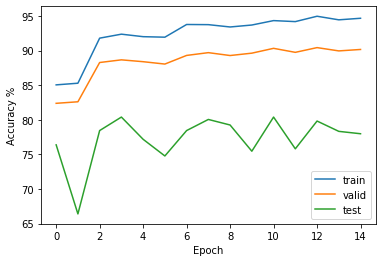

In [69]:
plt.plot(train_acc)
plt.plot(valid_acc)
plt.plot(test_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend(['train', 'valid', 'test'])
plt.show()

In [67]:
print(acc(valid_dataloader))
print(acc(test_dataloader))

90.15590200445435
77.98165137614679
